# Historical Weather & Climate Analysis

According to the National Oceanic and Atmospheric Administration, there are four major drivers of globally observed surface temperatures: greenhouse gasses, solar irradiance, volcanic aerosols, and the El Nino Southern Oscillation (ENSO).

This study will combine time series data from the following sources:

## Drivers:

1. Greenhouse Gases:

    https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.txt

    ... or available as a .csv here:

    https://gml.noaa.gov/ccgg/trends/data.html
    

2. Solar Irradiance:

    https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json
    

3. ENSO: 

    https://www.cpc.ncep.noaa.gov/data/indices/soi

Note: volcanic aerosol injections have been omited due to time constraints for this project. Where the other two natural drivers (solar irradiance and ENSO) adhere to cyclic behavior (~11 yr and 2 to 7 yrs, respectively), volcanic aerosol injections occur at random intervals, and have a slight cooling effect during the months and years following a release.

## Driven:

The objective is to determine whether the aforementioned drivers can be detected in local weather parameters in the Los Angeles area over the past 70 years. *Darksky.net* offers a nice repository of historical weather data, accessible as daily sets of hourly data at location-specific URLs. Both the date YYYY-MM-DD and coordinates latitude,longitude are required to form a complete URL. For example, if we want to gather hourly weather data for January 2, 2022 at the University of Southern California (USC) campus (lat,lon = 34.0224,-118.2851), the URL would be:


    https://darksky.net/details/34.0224,-118.2851/2022-01-02/us12/en
    
## Motivation, Observations, and Caveats:

Climate science is a field of enormous breadth and depth. This project, on the other hand, is simply an exercise in gathering, cleaning, organizing, and analyzing data. The chaotic dynamics of the atmospheric system present a rich collection of questions for futher study. A variety drivers to exist - including cloud cover, ozone, and axial precession - which have not been addressed here. Notably, the Darksky weather data sets do contain these parameters, so future investigation of them would be a reasonable extension of this work.

We begin by scraping and importing data from the sources listed above. Each data set is stored in its own table in a  structured query language (SQL) database. From here, the data is queried into pandas data frames, where it is a fairly straightforward task to clean and wrangle it for analysis. Finally, the data is merged into a common data data frame, which is then truncated to include only the time series data from 1950 to 2022 for each data set (the sunspot data goes all the way back to the 1700s!). 

It is important to note that the timescales of climate science are generally much greater than that of this study. Where we examine a mere 70 years of data here, paleoclimatology looks back through the millennia to characterize the dramatic changes throughout the epochs. 

That said, the reason we have decided to focus on the last 70 years (apart from limitations of time and processing power) is as follows: At turn of the 19th century into the 20th, the concentration of atmospheric CO2 was around 200 parts per million (ppm). It is presently just over 400 ppm. The ~1.69 trillion tons of CO2 that human activity has produced since the beginning of the industrial revolution constitutes a doubling of what was naturally occuring at the beginning of the 1900s.

The warming effect of CO2 is easy to see in the data. The clearest correlation in this combined data is between CO2 concentration and long-term temperature. This is certainly not ground-breaking; the warming effect of CO2 is fundamental and well-understood. The absorption spectrum of CO2 makes it transparent to visible light, but opaque in the infra-red. The earth is constantly bombarded by solar energy in the visible spectrum, but a portion of the infrared light that would otherwise radiate back into space is trapped and re-radiated back toward the surface by CO2 and other similar species, thereby causing surface temperatures to increase.

Our interactions with weather data are normally forward-looking. We tend to be much more concerned with forecasts than historical weather patterns. While day-to-day we may have only a vague suspicion of a warming climate, to see it borne out in the data is striking.

## The Data

The weather data set(s) for this project are enormous. Scraping each set took over 6 hours. Much of that is probably to do with my inexperience and lack of understanding of efficient programming. Nevertheless, I managed to collect two (nearly) full sets of weather data from 1950 through 2022. One set is for the City of Los Angeles, near the USC campus. The other is on the other side of the Pacific Ocean, in Manila, Philippines. There were a fair number of NaN's in the Manila set. 

The motivation for capturing weather data on opposite sides of the Pacific is to watch for any correlations with the El Nino Southern Oscillation (ENSO). The ENSO can be understood as a reversal of the normal flow of warm water in the equatorial Pacific from East to West. It is said that fishing crews off the western coast of Latin America hundreds of years ago noticed uncharacteristically warm waters and gave them the namesake: "blessed child." Such reversals can have dramatic impacts on both sides of the Pacific. In the west, areas such as the Philippines, which are accustomed to tropical climates with plentiful rain, suffer drought during ENSO anomalies. Conversely, the large mass of warm water lingering near the Americas has a reputation for bringing torrential rain and destructive flooding. 

The Southern Oscillation Index (SOI) is a measure of the likelihood of an ENSO event. Monitoring stations in the western Pacific look for telltale differences in ocean surface temperature and pressure. Anomalous readings sustained over a period of multiple months signify a high probability of an ENSO event.

## Analysis

The correlation of sunspot data to local surface temperatures appears to be relatively low, though in the early part of the time series, the peaks seem to coincide. The 11-year periodicity of the solar sunspot nuber (ssn) is not seen as a strong driver of either temperature set.

As we might expect, correlation between temperature and CO2 signals increases once the temperature signals have been smoothed. A simple moving average (SMA) function was developed as a more convenient method than the aggregation routine submitted previously.

Visualizations include heat maps for temperature data averaged over each month for the years from 1950 to 2021. These provide an interesting look at the increasing trends of individual months, as well as the overall trend of more frequent, warmer temperatures in both locations.

A stacked set of subplots shows the various time series data along a common time axis (which took more time than I'd like to admit to figure out). SOI and sunspot data are shown along with their smoothed counterparts, where only the smoothed temperature data are shown - the original temperature signal is quite noisy and not pleasing to look at.

A heat map of the correlation table for the merged data frame is also provided. Correlations are generally low, with the highest correlations being between CO2 concentration and smoothed temperature (0.71 & 0.84 for LA & Manila, respectively).

## Further Analysis

The data from Darksky is a veritable treasure trove. It seems almost a sacrilege to focus so narrowly on temperature. I think I'll continue this work, combining humidity, cloud cover, precipitation, and solar altitude and azimuth to look for any further interesting trends.

Tangentially, I'm especially interested in taking a look at the solar altitude and azimuth data to look for evidence of axial precession.

As someone who rides a bike just about everywhere I go, I'm also very interested in wind direction and velocity, which can make all the difference between a really pleasant commute and one that's a little less fun. This is also of obvious interest to those of us who enjoy flying paragliders when we're away from our computers.
    

## Imports, Functions, and Script

In [1]:
#!/usr/bin/env python3

from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
from sqlalchemy import create_engine
import sys

# CREATE SQL ENGINES... DATABASES IN THIS FILEPATH
demo_engine = create_engine('sqlite:///ScrapeDemo.db',echo=False)
engine = create_engine('sqlite:///FinalProjectGMH.db',echo=False)

#__________________________________________________________________________________________________________________
def coordinates(location):
    '''
    Uses the opencagedata geocoding API to return latitude and longitude for an input city name.
    
    Input: list of city name(s) as string(s). Defaults to Anchorage and Auckland (since I've already scraped LA
    and Manila. The idea is to get a few locations around the perimeter of the Pacific)
    '''
    if np.ndim(location) < 1: #if location entered as a string instead of a list containing a string...
        location = [location]
    
    my_key = '4ffeb0c77c5c4d9a8962be54e9d6c010'
    base_url = 'https://api.opencagedata.com/geocode/v1/json'
        
    latlon = {}
    for loc in location:
        encoded_loc = requests.utils.quote(loc)
        url = f'{base_url}?q={encoded_loc}&key={my_key}'
        try:
            js = requests.get(url).json()
            major_loc = js.get('results')[0] #likely to return many cities with the name. biggest is top of list.
            lat, lon = major_loc['geometry']['lat'], major_loc['geometry']['lng']
        except:
            print(f"could not get url for '{loc}'")
            lat, lon = None, None
        
        if lat:
            latlon[loc] = f'{lat:.4f},{lon:.4f}'
        else:
            latlon[loc] = None
            print('invalid location entered')
    return latlon

#_________________________________________________________________________________________________________________
def weather_data(location={'USC':'34.0224,-118.2851'}, start='1950-01-01', end='2022-01-01'):
    '''
    WARNING: RUNNING THIS FUNCTION WITH DEFAULT start & end ARGUMENTS WILL TAKE 6+ HOURS TO COMPLETE. 
    IT SCRAPES A darksky.net URL FOR EVERY SINGLE DAY FROM '1950-01-01' TO '2022-01-01' AT THE LOCATION SPECIFIED. 
    EACH DAY IS COMPRISED OF 24 OBSERVATIONS (ON THE HOUR) OF 24 DIFFERENT WEATHER PARAMETERS. 
    IT CREATES A DICTIONARY WITH 72 * 365 + LEAP DAYS = 26,299 ENTRIES, I.E., 1 DICT ENTRY PER DAY. 
    EACH DICT ENTRY IS THE RAW TEXT SCRAPED FROM THE URL FOR THAT DAY/LOCATION, CONTAINING 24 HR x 24 PARAMS = 576
    ELEMENTS. SO THAT'S 576 * 26,299 = 15,148,224 DATA ELEMENTS TOTAL.
    
    IT THEN WRANGLES THE DATA FROM THIS DICTIONARY INTO A DICTIONARY OF DATA FRAMES, WHICH ARE THEN APPENDED TO 
    ONE ANOTHER TO PRODUCE A SINGLE, COMPLETE DATAFRAME (THIS PART TAKES ROUGHLY HALF OF THE 6+ COMPLETION HOURS).
    THIS DATAFRAME IS THEN STORED AS A SQL TABLE WHICH CAN BE QUERRIED AS NEEDED.
    
    IF YOU DON'T WANT YOUR COMPUTER TIED UP FOR 6+ HOURS, YOU'RE PROBABLY BETTER OFF JUST QUERYING THIS
    DATA FROM THE SQL DATABASE 'FinalProjectGMH.db' PROVIDED IN THE ZIPPED FOLDER. I'LL PROBABLY JUST HAVE THE
    SCRIPT DO SUCH A QUERY AUTOMATICALLY INSTEAD OF CALLING THIS weather_data() FUNCTION. TO SHOW THAT THIS FUNCTION 
    ACTUALLY DOES WHAT IT SAYS IT DOES, I'LL HAVE THE SCRIPT CALL IT, BUT FOR AN EXTREMELY TRUNCATED DATE RANGE.
    IT WILL SAVE THE DATA TO AN ENTIRELY DIFFERENT ScrapeDemo.db SQL DATABASE, SO AS NOT TO INTERFERE WITH THE OTHER
    ANALYSIS TASKS THAT PULL FROM THE TRUE (AND MUCH LARGER) FinalProjectGMH.db DATABASE.
    
    THERE'S CERTAINLY ROOM FOR IMPROVEMENT HERE > I PROBABLY SHOULD HAVE USED SOME KIND OF BATCH PROCESSING FOR THIS
    SINCE IT'S OBVIOUSLY NOT SUPER ROBUST AND IT'D BE NICE TO AT LEAST RETAIN WHAT'S BEEN SCRAPED SO FAR IN THE 
    EVENT IT FAILS OUT. FRANKLY, I WAS PRETTY SHOCKED IT ACTUALLY WORKED THE FIRST TIME I RAN IT FOR THE WHOLE 
    72-YEAR DATE RANGE (USC CAMPUS LOCATION), AT WHICH POINT I HADN'T EVEN PROVIDED ANY TRY/EXCEPT BLOCKS TO CATCH 
    BAD URLs. THE SECOND TIME I TRIED IT (MANILA), I LET IT RUN FOR 12+ HOURS BEFORE FINALLY INTERRUPTING IT. I 
    STILL DON'T KNOW WHAT THE ISSUE WAS - SEEMS LIKE PERHAPS SOME KIND OF INFINTE LOOP(?) BUT IT DID RENDER USEFUL 
    DATA. THIRD ATTEMPT (DARWIN, AUSTRALIA) FAILED WITH THE DREADED "COOL YOUR JETS, BUDDY - THAT'S QUITE ENOUGH 
    SERVER HITS FOR YOU!" MESSAGE FROM Darksky.net :/ ... IT APPEARS MY IP HAS NOT BEEN OUTRIGHT BLOCKED, AS I'M 
    STILL ABLE TO SCRAPE TRUNCATED DATE RANGES. I'VE YET TO TRY ANOTHER FULL RUN.
    
    '''
    date_range = pd.date_range(start=start, end=end, freq='D')
    days = [str(day)[:10] for day in date_range]#[:10] to exclude HH:MM:SS component
    urls = []
    for day in days:
        url = f'https://darksky.net/details/{list(location.values())[0]}/{day}/us12/en' 
        urls.append(url)
    
    raw_days = dict.fromkeys(days) #let's first just collect the raw text from each URL in here...
    for day, url in list(zip(days,urls)):
        try:
            page = requests.get(url)
            soup = BeautifulSoup(page.content, 'html.parser')
            dataTag = soup.findAll('script')[1] #second <script> tag contains all hourly data... the jackpot
        except IndexError:
            print(f'could not make dataTag for {day}')
            dataTag = None
            
        if dataTag:
            raw_days[day] = dataTag.text
        else:
            print(f"dictionary value for key '{day}' entered as None Type")
            raw_days[day] = None

    #TURN RAW "DICT-LIKE" TEXT INTO ACTUAL DICTIONARY OF ALL DAYS' ACTUAL DATA
    dict_days = dict.fromkeys(days)
    for day, txt in raw_days.items():
        hours = re.findall(r'(\{.*?\})',txt) #list type, containing dict-like elements: {..hour's text data..}
        hourly_data = [] #will append actual hourly dictionaries to this list
        for hour in hours[:24]: #leave out the last two - they're not hours... other stuff we don't want
            data_list = hour.split(',') #split each {'dictionary'} on commas into its key-val pairs
            keys = ['time',
                'summary',
                'icon',
                'precipIntensity',
                'precipProbability',
                'precipType',
                'temperature',
                'apparentTemperature',
                'dewPoint',
                'humidity',
                'pressure',
                'windSpeed',
                'windGust',
                'windBearing',
                'cloudCover',
                'uvIndex',
                'visibility',
                'ozone',
                'azimuth',
                'altitude',
                'dni',
                'ghi',
                'dhi',
                'etr'
               ]
            
            intstr = r':(-*\d+)'       #regex to get integer values
            fltstr = r':(-*\d+\.\d+)'  #regex to get float values

            hour_dict = dict.fromkeys(keys)
            for data in data_list:
                for key in keys:
                    if key in data:

                        if re.search(fltstr, data):
                            valflt = float(''.join(re.findall(fltstr, data)))
                            hour_dict[key] = valflt

                        elif re.search(intstr, data):
                            valint = int(''.join(re.findall(intstr, data)))
                            hour_dict[key] = valint

                        else:
                            valstr = str(''.join(re.findall(r':"(.*)"', data)))
                            hour_dict[key] = valstr
                            
            hourly_data.append(hour_dict)

        dict_days[day] = hourly_data #store the list of hourly dictionaries in this day's dictionary spot

    #MELT FROM DICT OF HOURS INTO DICT OF "KEYS" I.E., WEATHER PARAMETERS (24-ELM LIST VARIABLE ABOVE)
    melted_days = dict.fromkeys(days)
    for day, hours in dict_days.items():
        melted = dict.fromkeys(keys)
        for k in keys:
            for h in hours[:24]: #the last two are not hourly data
                if melted[k]:#if already any entry for this weather parameter ("key"), append next hour's value
                    melted[k].append(h[k])
                else:#otherwise, this is the first entry for this parameter...
                    melted[k] = [h[k]]
        melted_days[day] = melted
    
    #GATHER INTO DICTIONARY OF DATA FRAMES
    dframes = dict.fromkeys(days)
    for day, data in melted_days.items():
        try:
            dframes[day] = pd.DataFrame(data)
        except IndexError:
            print(f'cannot create dataframe for {day}')
            dframes[day] = None
            
    #APPEND DATA FRAMES INTO ONE GIANT ONE ... THIS TAKES 3+ HOURS TO COMPLETE
    df_list = list(dframes.values())
    df_complete = df_list[0]
    for i in range(len(df_list)-1):
        try:
            df_complete = df_complete.append(df_list[i+1])
        except IndexError:
            print(f'could not append dataframe {i+1}')
            
    #STORE THIS GIANT DF IN A SQL DB TABLE
    df_complete.to_sql(f'weather_{list(location.keys())[0]}', con=demo_engine, if_exists='replace')
    return df_complete


#______________________________________________________________________________________________________________
def solar_data():
    '''
    Scrape and parse json data. collect in dataframe. connect sqlalchemy engine and store
    dataframe as table in database
    '''
    url = 'https://services.swpc.noaa.gov/json/solar-cycle/observed-solar-cycle-indices.json'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    solar_data = json.loads(soup.text)
    df_solar = pd.DataFrame(solar_data)
    df_solar.rename(columns={'time-tag':'time'}, inplace=True)
    df_solar['time'] = pd.to_datetime(df_solar['time'])
    df_solar.to_sql('solar_cycle', con=demo_engine, if_exists='replace')
#     return df_solar

#_______________________________________________________________________________________________________________
def ENSO_data():
    '''
    Scrape ENSO data. save to SQL db.
    '''
    url = 'https://www.cpc.ncep.noaa.gov/data/indices/soi'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    raw = soup.text.splitlines()
    
    start, end = 1951, 2022
    ENSO = []
    for line in raw[4:(end-start+4)]:
        for element in line.split()[1:]:
            ENSO.append(float(element))
            
    months = pd.date_range(start='1951-01', end='2022-01', freq='M')
    
    df_ENSO = pd.DataFrame({'time':months, 'SOI':ENSO})
    df_ENSO['time'] = pd.to_datetime(df_ENSO['time'])
    df_ENSO.to_sql('ENSO', con=demo_engine, if_exists='replace')
#     return df_ENSO

#________________________________________________________________________________________________________________
def CO2emissions_data():
    df_emissions = pd.read_csv('annual-co2-emissions-per-country.csv')
    df_emissions.rename(columns={'Year':'time'}, inplace=True)
    df_emissions['time'] = pd.to_datetime(df_emissions['time'], format='%Y')
    df_emissions = df_emissions.pivot(index='time', columns='Entity', values='Annual CO2 emissions')
    df_emissions.to_sql('CO2_emitted', con=demo_engine, if_exists='replace')
#     return df_emissions

#_________________________________________________________________________________________________________________
def CO2ppm_data():
    df_ppm = pd.read_csv('co2_mm_mlo.csv', skiprows=[x for x in range(51)])
    time = pd.to_datetime(df_ppm.year.apply(str)+'-'+df_ppm.month.apply(str)).to_frame()
    time.columns=['time']
    df_ppm = df_ppm.merge(time, left_index=True, right_index=True)
    df_ppm['time'] = pd.to_datetime(df_ppm['time'])
    df_ppm.set_index('time', inplace=True)
    df_ppm.to_sql('CO2_ppm', con=demo_engine, if_exists='replace')
#     return df_ppm
    
#Simple Moving (rolling) Average (SMA):_____________________________________________________________________________________
def SMA(df,column,window_nobs,inplace=False,time_unit=None):
    valid_time_units = {"hourly":24*365, #number of hourly observations to make a 1-yr window
                        "daily":365, #... "..."
                        "monthly":12,
                        "yearly":1}
    
    if df is df_LA or df is df_Manila:
        unit = 24*365 #hourly data
    elif df is df_ENSO or df is df_solar or df is df_CO2ppm:
        unit = 12 #monthly data
    elif df is df_CO2emitted:
        unit = 1 #yearly data
    else:
        if time_unit in valid_time_units:
#             unit = [x for x in time_unit.values()][0]
            unit = valid_time_units[time_unit]
        else:
            print(f'non-standard data frame "{df}", *unit arg required, Nonetype returned.')
            return None
        
    if inplace==True:
        df[f'SMA_{window_nobs}_{column}'] = df[column].rolling(unit*window_nobs,min_periods=1).mean()[unit*window_nobs:]
        return df
    else:
        return df[column].rolling(unit*window_nobs, min_periods=1).mean()[unit*window_nobs:]

#_________________________________________________________________________________________________________________
def make_datetime(df_list):
    for df in df_list:
        if df is df_LA or df is df_Manila:
            df['time'] = pd.to_datetime(df['time'], unit='s') #unit='s' for 'numpy.float64' types
        else:
            df['time'] = pd.to_datetime(df['time']) #no additional argument for 'str' types
            
#_________________________________________________________________________________________________________________
def merge_dframes(df_list):
    dframes_merged = df_list[0]
    for i in range(len(df_list)-1):
        dframes_merged = pd.merge(dframes_merged, df_list[i+1], on='time', how='outer')

    return dframes_merged

#_________________________________________________________________________________________________________________
#_________________________________________________________________________________________________________________
################################################ SCRIPT ##########################################################
#_________________________________________________________________________________________________________________

    

if __name__ == "__main__":

    if len(sys.argv) == 1: #if only arg is the filename of this script ...
        '''if the only arg is the filename of this script, the following will occur:
        
           1. Truncated weather data for USC will be scraped and saved in the ScrapeDemo.db. All other data will 
               be scraped/imported and saved in their own respective tables in ScrapeDemo.db
           2. Data frames will be constructed via queries of the FinalProjectGMH.db included in this folder.
           3. these data frames will be cleaned and merged for analysis.
           4. heat maps for temperature data will be produced.
           5. A set of stacked subplots will be produced.
           6. A heat map of the correlation table will be produced.'''
        
        #1. scrape & import data to ScrapeDemo.db
        weather_data(start='1985-01-01', end='1985-01-10') #10 days takes this long... imagine 72 years!!
        solar_data()
        ENSO_data()
        CO2emissions_data()
        CO2ppm_data()
        
        #2. pull data from FinalProjectGMH.db
        df_LA = pd.read_sql(f"SELECT time, temperature FROM 'weather_Los Angeles'", con=engine)
        df_Manila = pd.read_sql(f"SELECT time, temperature FROM weather_Manila", con=engine)
        df_solar = pd.read_sql(f"SELECT time, ssn, smoothed_ssn FROM solar_cycle", con=engine)
        df_ENSO = pd.read_sql(f"SELECT time, SOI FROM ENSO", con=engine)
        df_CO2emitted = pd.read_sql(f"SELECT time, World FROM CO2_emitted", con=engine)
        df_CO2ppm = pd.read_sql(f"SELECT time, interpolated FROM CO2_ppm", con=engine)
        
        #3. clean, merge, truncate (Solar Data goes back way farther than all the others)
        dframes = [df_LA, df_Manila, df_CO2emitted, df_CO2ppm, df_solar, df_ENSO]
        make_datetime(dframes)
        merged = merge_dframes(dframes)
        merged.rename(columns={'temperature_x':'temp_LA',
                       'temperature_y':'temp_Manila',
                       'World':'CO2_emissions',
                       'interpolated':'CO2_ppm'},
                       inplace=True)
        truncated = merged[merged['time'] >= pd.to_datetime('1950-01-01')].sort_values(by='time')
        truncated.set_index('time', inplace=True)
        
        #4. heat maps for temperature data
        pvt_LA = df_LA.pivot_table(index=pd.to_datetime(df_LA['time'], unit='s').dt.month.rename('month'),
                   columns=pd.to_datetime(df_LA['time'], unit='s').dt.year.rename('year'),
                   values='temperature',
                   aggfunc=np.mean)
        pvt_Manila = df_Manila.pivot_table(index=pd.to_datetime(df_Manila['time'], unit='s').dt.month.rename('month'),
                   columns=pd.to_datetime(df_Manila['time'], unit='s').dt.year.rename('year'),
                   values='temperature',
                   aggfunc=np.mean)
        plt.figure(figsize=(16,6))
        ax = sns.heatmap(pvt_LA.drop(columns=[2022.0]))
        plt.figure(figsize=(16,6))
        ax = sns.heatmap(pvt_Manila.drop(columns=[2022.0]).fillna(method='ffill'))
        
        #5. stacked subplots
        fig, axes = plt.subplots(6,1, figsize=(16,18), sharex=True)
        axes[0].set_xlim(left=truncated.index[0], right=truncated.index[-1])
        axes[0].plot(truncated.CO2_emissions.dropna(), label='CO2 tons')
        axes[0].legend()
        axes[0].grid()
        axes[1].plot(truncated.CO2_ppm.dropna(), label='CO2 ppm')
        axes[1].legend()
        axes[1].grid()
        axes[2].plot(truncated.SOI.dropna(), label='SOI anomaly')
        axes[2].plot(SMA(truncated, 'SOI', 20, time_unit='daily'), label='smoothed SOI')
        axes[2].legend()
        axes[2].grid()
        axes[3].plot(SMA(truncated, 'temp_LA', 2, time_unit='hourly'), label='LA temp smoothed')
        axes[3].legend()
        axes[3].grid()
        axes[4].plot(SMA(truncated, 'temp_Manila', 2, time_unit='hourly'), label='Manila temp smoothed')
        axes[4].legend()
        axes[4].grid()
        axes[5].plot(truncated.ssn.dropna(), label='ssn')
        axes[5].plot(SMA(truncated, 'ssn', 12, time_unit='daily'), label='ssn smoothed')
        axes[5].legend()
        axes[5].grid()
        plt.show()
        
        #6. correlation table with heatmap
        SMA(truncated, 'SOI', 20, time_unit='daily', inplace=True)
        SMA(truncated, 'temp_LA', 2, time_unit='hourly', inplace=True)
        SMA(truncated, 'temp_Manila', 2, time_unit='hourly', inplace=True)
        SMA(truncated, 'ssn', 12, time_unit='daily', inplace=True)
        ax1 = sns.heatmap(truncated.corr())

    elif sys.argv[1] == '--scrape_loc': #'--scrape_loc: location' where location is a location name
        '''if two arguments are present, use the second as the inpt to the coordinates() function, and 
        scrape a truncated date range (1985-01-01 to 1985-01-10) of weather data at that location...
        
        A new table will be created in the ScrapeDemo.db containing this scraped data.'''
        
        print(f'boop... beep... boop... processing location "{sys.argv[2]}" ...')
        weather_data(coordinates(sys.argv[2]), start='1985-01-01', end='1985-01-10')
        print(f'success! check folder for new table: "weather_{sys.argv[2]}" in ScrapeDemo.db')
        
    elif sys.argv[1] == '--super_huge_long_giant_weather_scrape': #--yeah, that's right... it's long for a reason
        '''again, the second argument is the user's choice of location, but this time the full 72-year date
        range is scraped. 
        
        >>> BE WARNED: THIS WILL LIKELY TAKE AT LEAST 6 HOURS TO COMPLETE !!!!'''
        
        print('BE WARNED: THIS WILL LIKELY TAKE AT LEAST 6 HOURS TO COMPLETE !!!! ... good luck...')
        weather_data(coordinates(sys.argv[2]))

else:
    print(f'... Importing module {__name__} ...')

## Scrape / Import Into `ScrapeDemo.db`

In [2]:
solar_data()

In [3]:
ENSO_data()

In [4]:
CO2emissions_data()

In [5]:
CO2ppm_data()

## The Process:

1. Scrape/import data and dump each set into its own table in a SQL database
2. Read data from SQL tables into pandas dataframes: `pd.sql_read()`
3. Clean up data frames (using any of the following, as necessary):
* `df.drop(columns=['columns_to_drop'], inplace=True)`
* `df.rename(columns={'old_name':'new_name'}, inplace=True)`
* `df['time'] = pd.to_datetime(df['time'])`
* `df.set_index('time', inplace=True)`
* `df.pivot(index='Year', columns='Entity', values='CO2_emissions')`
4. Smooth the noisy, high-sample-rate data as needed using `SMA()` function defined above
5. You can do a multi-axes plot now, without normalizing or merging data frames. NOTE: correlation analysis `df.corr()` does NOT require input data to be normalized to a similar scale.
6. Merge select columns from data frames and do `df.corr()`


## 2. Read Data from `FinalProjectGMH.db` Tables into Data Frames

In [6]:
df_LA = pd.read_sql(f"SELECT time, temperature FROM 'weather_Los Angeles'", con=engine)
df_Manila = pd.read_sql(f"SELECT time, temperature FROM weather_Manila", con=engine)
df_solar = pd.read_sql(f"SELECT time, ssn, smoothed_ssn FROM solar_cycle", con=engine)
df_ENSO = pd.read_sql(f"SELECT time, SOI FROM ENSO", con=engine)
df_CO2emitted = pd.read_sql(f"SELECT time, World FROM CO2_emitted", con=engine)
df_CO2ppm = pd.read_sql(f"SELECT time, interpolated FROM CO2_ppm", con=engine)

### Total Global CO2 Emissions (tons):

... since the industrial revolution

In [7]:
df_CO2emitted['World'].sum()

1696524177053.0

## 3. Clean Data Frames

Weather data was scraped and SQL-tabled with original Unix Epoch time...

In [8]:
dframes = [df_LA, df_Manila, df_CO2emitted, df_CO2ppm, df_solar, df_ENSO]

In [9]:
for df in dframes:
    print(type(df['time'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [10]:
make_datetime(dframes)

In [11]:
for df in dframes:
    print(type(df['time'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [12]:
merged = merge_dframes(dframes)

In [13]:
merged

,time,temperature_x,temperature_y,World,interpolated,ssn,smoothed_ssn,SOI
0,1950-01-01 08:00:00,49.19,88.99,NaN,NaN,NaN,NaN,NaN
1,1950-01-01 09:00:00,49.84,86.24,NaN,NaN,NaN,NaN,NaN
2,1950-01-01 10:00:00,48.50,81.95,NaN,NaN,NaN,NaN,NaN
3,1950-01-01 11:00:00,48.10,80.86,NaN,NaN,NaN,NaN,NaN
4,1950-01-01 12:00:00,49.04,79.61,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2547413,1949-09-01 00:00:00,NaN,NaN,NaN,NaN,205.8,176.1,NaN
2547414,1949-10-01 00:00:00,NaN,NaN,NaN,NaN,186.3,171.4,NaN
2547415,1949-11-01 00:00:00,NaN,NaN,NaN,NaN,203.2,169.4,NaN
2547416,1949-12-01 00:00:00,NaN,NaN,NaN,NaN,166.6,167.1,NaN


In [14]:
merged['time']

0         1950-01-01 08:00:00
1         1950-01-01 09:00:00
2         1950-01-01 10:00:00
3         1950-01-01 11:00:00
4         1950-01-01 12:00:00
                  ...        
2547413   1949-09-01 00:00:00
2547414   1949-10-01 00:00:00
2547415   1949-11-01 00:00:00
2547416   1949-12-01 00:00:00
2547417   2022-04-01 00:00:00
Name: time, Length: 2547418, dtype: datetime64[ns]

In [15]:
merged.rename(columns={'temperature_x':'temp_LA',
                       'temperature_y':'temp_Manila',
                       'World':'CO2_emissions',
                       'interpolated':'CO2_ppm'
                      }, inplace=True)

In [16]:
merged.columns

Index(['time', 'temp_LA', 'temp_Manila', 'CO2_emissions', 'CO2_ppm', 'ssn',
       'smoothed_ssn', 'SOI'],
      dtype='object')

In [17]:
truncated = merged[merged['time'] >= pd.to_datetime('1950-01-01')].sort_values(by='time')

In [18]:
truncated.set_index('time', inplace=True)

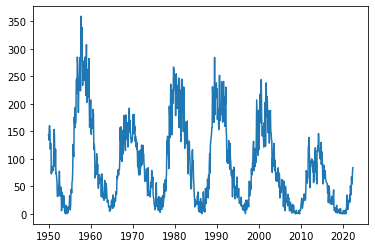

In [19]:
plt.plot(truncated['ssn'].dropna())

In [20]:
truncated.corr()

,temp_LA,temp_Manila,CO2_emissions,CO2_ppm,ssn,smoothed_ssn,SOI
temp_LA,1.000000,-0.105128,0.098056,0.141530,0.000868,-0.017432,0.001272
temp_Manila,-0.105128,1.000000,0.280584,0.247779,-0.025790,-0.043025,-0.061647
CO2_emissions,0.098056,0.280584,1.000000,0.985557,-0.279334,-0.291168,NaN
CO2_ppm,0.141530,0.247779,0.985557,1.000000,-0.333483,-0.360546,NaN
ssn,0.000868,-0.025790,-0.279334,-0.333483,1.000000,0.961712,NaN
smoothed_ssn,-0.017432,-0.043025,-0.291168,-0.360546,0.961712,1.000000,NaN
SOI,0.001272,-0.061647,NaN,NaN,NaN,NaN,1.000000


In [21]:
pvt_LA = df_LA.pivot_table(index=pd.to_datetime(df_LA['time'], unit='s').dt.month.rename('month'),
                   columns=pd.to_datetime(df_LA['time'], unit='s').dt.year.rename('year'),
                   values='temperature',
                   aggfunc=np.mean)

In [22]:
pvt_Manila = df_Manila.pivot_table(index=pd.to_datetime(df_Manila['time'], unit='s').dt.month.rename('month'),
                   columns=pd.to_datetime(df_Manila['time'], unit='s').dt.year.rename('year'),
                   values='temperature',
                   aggfunc=np.mean)

In [23]:
pvt_LA.columns

Float64Index([1950.0, 1951.0, 1952.0, 1953.0, 1954.0, 1955.0, 1956.0, 1957.0,
              1958.0, 1959.0, 1960.0, 1961.0, 1962.0, 1963.0, 1964.0, 1965.0,
              1966.0, 1967.0, 1968.0, 1969.0, 1970.0, 1971.0, 1972.0, 1973.0,
              1974.0, 1975.0, 1976.0, 1977.0, 1978.0, 1979.0, 1980.0, 1981.0,
              1982.0, 1983.0, 1984.0, 1985.0, 1986.0, 1987.0, 1988.0, 1989.0,
              1990.0, 1991.0, 1992.0, 1993.0, 1994.0, 1995.0, 1996.0, 1997.0,
              1998.0, 1999.0, 2000.0, 2001.0, 2002.0, 2003.0, 2004.0, 2005.0,
              2006.0, 2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0,
              2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0,
              2022.0],
             dtype='float64', name='year')

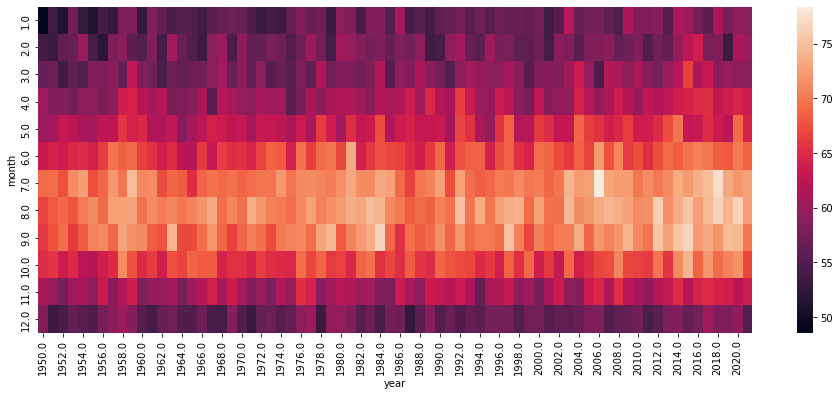

In [24]:
plt.figure(figsize=(16,6))
ax = sns.heatmap(pvt_LA.drop(columns=[2022.0]))

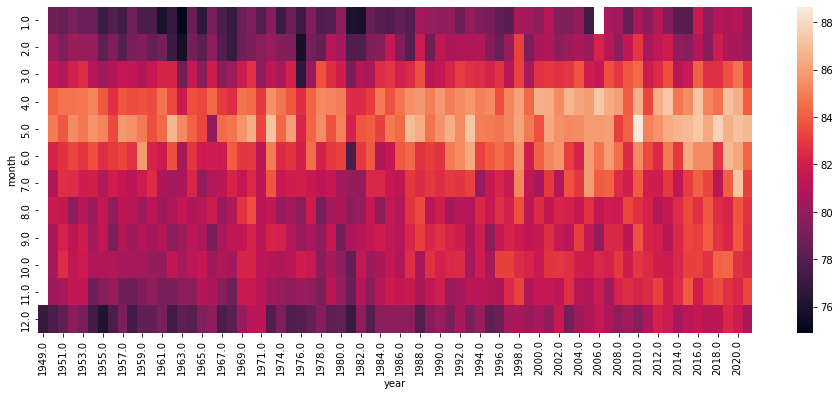

In [25]:
plt.figure(figsize=(16,6))
ax = sns.heatmap(pvt_Manila.drop(columns=[2022.0]).fillna(method='ffill'))

In [26]:
truncated.index

DatetimeIndex(['1950-01-01 00:00:00', '1950-01-01 01:00:00',
               '1950-01-01 02:00:00', '1950-01-01 03:00:00',
               '1950-01-01 04:00:00', '1950-01-01 05:00:00',
               '1950-01-01 06:00:00', '1950-01-01 07:00:00',
               '1950-01-01 08:00:00', '1950-01-01 09:00:00',
               ...
               '2022-01-02 01:00:00', '2022-01-02 02:00:00',
               '2022-01-02 03:00:00', '2022-01-02 04:00:00',
               '2022-01-02 05:00:00', '2022-01-02 06:00:00',
               '2022-01-02 07:00:00', '2022-02-01 00:00:00',
               '2022-03-01 00:00:00', '2022-04-01 00:00:00'],
              dtype='datetime64[ns]', name='time', length=631078, freq=None)

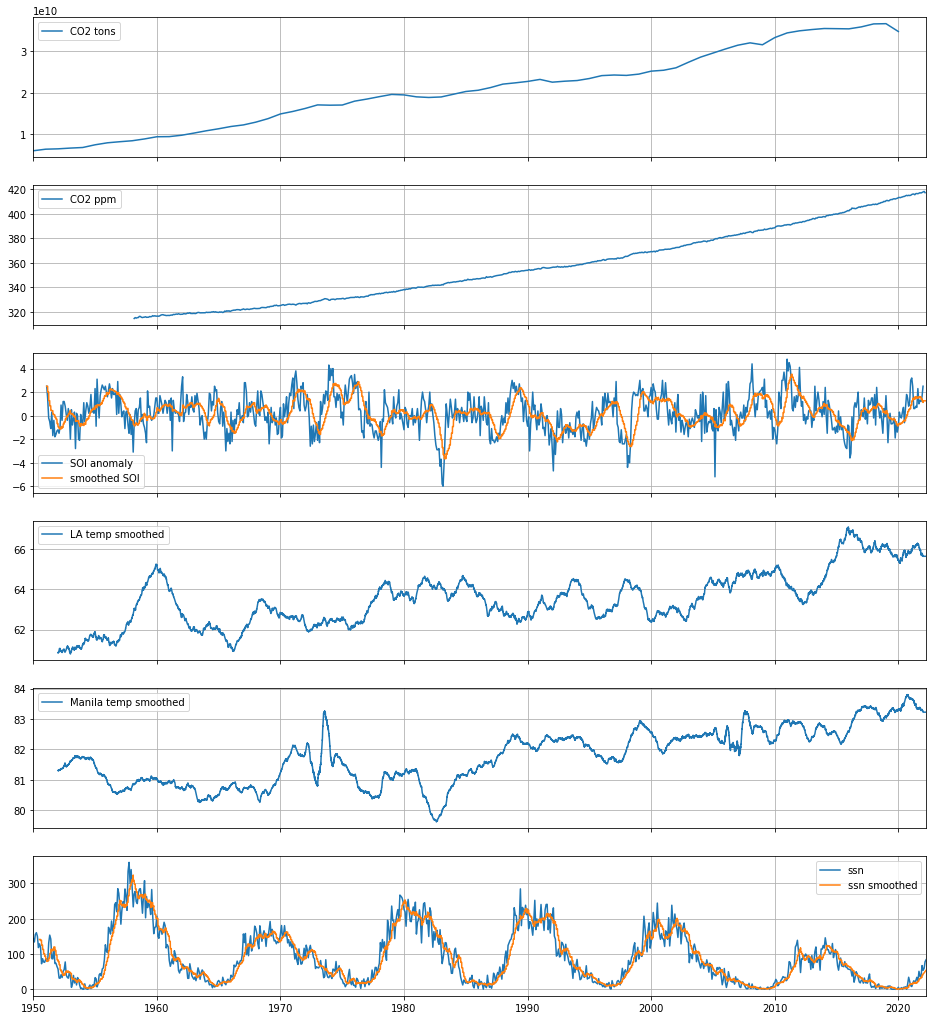

In [27]:
fig, axes = plt.subplots(6,1, figsize=(16,18), sharex=True)

axes[0].set_xlim(left=truncated.index[0], right=truncated.index[-1])
axes[0].plot(truncated.CO2_emissions.dropna(), label='CO2 tons')
axes[0].legend()
axes[0].grid()
axes[1].plot(truncated.CO2_ppm.dropna(), label='CO2 ppm')
axes[1].legend()
axes[1].grid()
axes[2].plot(truncated.SOI.dropna(), label='SOI anomaly')
axes[2].plot(SMA(truncated, 'SOI', 20, time_unit='daily'), label='smoothed SOI')
axes[2].legend()
axes[2].grid()
axes[3].plot(SMA(truncated, 'temp_LA', 2, time_unit='hourly'), label='LA temp smoothed')
axes[3].legend()
axes[3].grid()
axes[4].plot(SMA(truncated, 'temp_Manila', 2, time_unit='hourly'), label='Manila temp smoothed')
axes[4].legend()
axes[4].grid()
axes[5].plot(truncated.ssn.dropna(), label='ssn')
axes[5].plot(SMA(truncated, 'ssn', 12, time_unit='daily'), label='ssn smoothed')
axes[5].legend()
axes[5].grid()

In [28]:
SMA(truncated, 'SOI', 20, time_unit='daily', inplace=True)
SMA(truncated, 'temp_LA', 2, time_unit='hourly', inplace=True)
SMA(truncated, 'temp_Manila', 2, time_unit='hourly', inplace=True)
SMA(truncated, 'ssn', 12, time_unit='daily', inplace=True)

,temp_LA,temp_Manila,CO2_emissions,CO2_ppm,ssn,smoothed_ssn,SOI,SMA_20_SOI,SMA_2_temp_LA,SMA_2_temp_Manila,SMA_12_ssn
time,,,,,,,,,,,
1950-01-01 00:00:00,NaN,75.60,6.003238e+09,NaN,143.9,162.8,NaN,NaN,NaN,NaN,NaN
1950-01-01 01:00:00,NaN,79.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01 02:00:00,NaN,79.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01 03:00:00,NaN,82.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-01 04:00:00,NaN,85.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-02 06:00:00,50.71,NaN,NaN,NaN,NaN,NaN,NaN,1.26,65.622068,83.223074,44.500000
2022-01-02 07:00:00,50.21,NaN,NaN,NaN,NaN,NaN,NaN,1.26,65.621838,83.222901,44.500000
2022-02-01 00:00:00,NaN,NaN,NaN,418.36,59.7,-1.0,NaN,1.26,65.622456,83.222840,46.671429


In [29]:
truncated.corr()

,temp_LA,temp_Manila,CO2_emissions,CO2_ppm,ssn,smoothed_ssn,SOI,SMA_20_SOI,SMA_2_temp_LA,SMA_2_temp_Manila,SMA_12_ssn
temp_LA,1.000000,-0.105128,0.098056,0.141530,0.000868,-0.017432,0.001272,-0.024904,0.131946,0.075912,-0.001859
temp_Manila,-0.105128,1.000000,0.280584,0.247779,-0.025790,-0.043025,-0.061647,-0.066737,0.111411,0.168805,-0.059008
CO2_emissions,0.098056,0.280584,1.000000,0.985557,-0.279334,-0.291168,NaN,-0.032967,0.737117,0.791229,-0.262079
CO2_ppm,0.141530,0.247779,0.985557,1.000000,-0.333483,-0.360546,NaN,0.023286,0.710587,0.849589,-0.353466
ssn,0.000868,-0.025790,-0.279334,-0.333483,1.000000,0.961712,NaN,0.039486,-0.152449,-0.275050,0.955831
smoothed_ssn,-0.017432,-0.043025,-0.291168,-0.360546,0.961712,1.000000,NaN,0.022864,-0.168074,-0.297705,0.983741
SOI,0.001272,-0.061647,NaN,NaN,NaN,NaN,1.000000,0.587977,-0.094172,0.136979,-0.073932
SMA_20_SOI,-0.024904,-0.066737,-0.032967,0.023286,0.039486,0.022864,0.587977,1.000000,-0.164324,0.045610,-0.002520
SMA_2_temp_LA,0.131946,0.111411,0.737117,0.710587,-0.152449,-0.168074,-0.094172,-0.164324,1.000000,0.523734,-0.124801
SMA_2_temp_Manila,0.075912,0.168805,0.791229,0.849589,-0.275050,-0.297705,0.136979,0.045610,0.523734,1.000000,-0.284530


<AxesSubplot:>

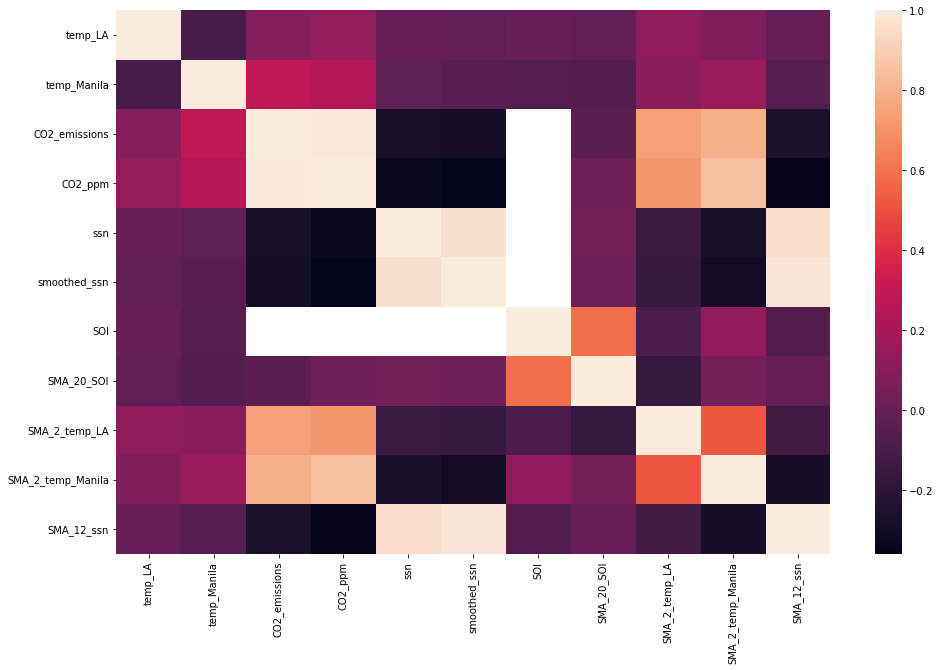

In [30]:
plt.figure(figsize=(16,10))
sns.heatmap(truncated.corr())

## Readme...

To run this script at the command line, navigate to the appropriate folder and type one of the following three options:

OPTION 1: get all data make some nice visualizations...

$> python Climate.py 

    Simply typing the name of the file without any additional flags or arguments will perform the following:
    
   1. Weather data for USC will be scraped for a truncated date range (10 days) and saved in ScrapeDemo.db. 
    All other data will be scraped/imported and saved in their own respective tables in ScrapeDemo.db, where
    it will sit, doing nothing other than proving that the scraping functionality works. If you navigate to 
    the folder, you will find that the ScrapeDemo.db file has been created and populated with the data                   tables.
   2. Data frames will be constructed via queries of the FinalProjectGMH.db, which is included in this folder.
   3. These data frames will be cleaned and merged for analysis.
   4. Heat maps for temperature data will be produced.
   5. A set of stacked subplots for the time series data will be produced.
   6. The head of the final, merged dataframe is printed.
   
OPTION 2: scrape truncated weather data for a location of your choice

$> python Climate.py "--scrape_loc 'name_of_location'"

        '''use the second as the input to the coordinates() function, and 
        scrape a truncated date range (1985-01-01 to 1985-01-10) of weather data at that location...
        
        A new table will be created in the ScrapeDemo.db containing this scraped data.'''


OPTION 3: Do a super huge giant weather scrape... at your own risk...

$> python Climate.py "--super_huge_long_giant_weather_scrape 'name_of_location'"

    '''again, the second argument is the user's choice of location, but this time the full 72-year date
        range is scraped. 
        
        >>> BE WARNED: THIS WILL LIKELY TAKE AT LEAST 6 HOURS TO COMPLETE !!!!'''

    WARNING: RUNNING THIS FUNCTION WITH DEFAULT start & end ARGUMENTS WILL TAKE 6+ HOURS TO COMPLETE. 
    IT SCRAPES A darksky.net URL FOR EVERY SINGLE DAY FROM '1950-01-01' TO '2022-01-01' AT THE LOCATION SPECIFIED. 
    EACH DAY IS COMPRISED OF 24 OBSERVATIONS (ON THE HOUR) OF 24 DIFFERENT WEATHER PARAMETERS. 
    IT CREATES A DICTIONARY WITH 72 * 365 + LEAP DAYS = 26,299 ENTRIES, I.E., 1 DICT ENTRY PER DAY. 
    EACH DICT ENTRY IS THE RAW TEXT SCRAPED FROM THE URL FOR THAT DAY/LOCATION, CONTAINING 24 HR x 24 PARAMS = 576
    ELEMENTS. SO THAT'S 576 * 26,299 = 15,148,224 DATA ELEMENTS TOTAL.
    
    IT THEN WRANGLES THE DATA FROM THIS DICTIONARY INTO A DICTIONARY OF DATA FRAMES, WHICH ARE THEN APPENDED TO 
    ONE ANOTHER TO PRODUCE A SINGLE, COMPLETE DATAFRAME (THIS PART TAKES ROUGHLY HALF OF THE 6+ COMPLETION HOURS).
    THIS DATAFRAME IS THEN STORED AS A SQL TABLE WHICH CAN BE QUERRIED AS NEEDED.
    
    IF YOU DON'T WANT YOUR COMPUTER TIED UP FOR 6+ HOURS, YOU'RE PROBABLY BETTER OFF JUST QUERYING THIS
    DATA FROM THE SQL DATABASE 'FinalProjectGMH.db' PROVIDED IN THE ZIPPED FOLDER. I'LL PROBABLY JUST HAVE THE
    SCRIPT DO SUCH A QUERY AUTOMATICALLY INSTEAD OF CALLING THIS weather_data() FUNCTION. TO SHOW THAT THIS FUNCTION 
    ACTUALLY DOES WHAT IT SAYS IT DOES, I'LL HAVE THE SCRIPT CALL IT, BUT FOR AN EXTREMELY TRUNCATED DATE RANGE.
    IT WILL SAVE THE DATA TO AN ENTIRELY DIFFERENT ScrapeDemo.db SQL DATABASE, SO AS NOT TO INTERFERE WITH THE OTHER
    ANALYSIS TASKS THAT PULL FROM THE TRUE (AND MUCH LARGER) FinalProjectGMH.db DATABASE.
    
    THERE'S CERTAINLY ROOM FOR IMPROVEMENT HERE > I PROBABLY SHOULD HAVE USED SOME KIND OF BATCH PROCESSING FOR THIS
    SINCE IT'S OBVIOUSLY NOT SUPER ROBUST AND IT'D BE NICE TO AT LEAST RETAIN WHAT'S BEEN SCRAPED SO FAR IN THE 
    EVENT IT FAILS OUT. FRANKLY, I WAS PRETTY SHOCKED IT ACTUALLY WORKED THE FIRST TIME I RAN IT FOR THE WHOLE 
    72-YEAR DATE RANGE (USC CAMPUS LOCATION), AT WHICH POINT I HADN'T EVEN PROVIDED ANY TRY/EXCEPT BLOCKS TO CATCH 
    BAD URLs. THE SECOND TIME I TRIED IT (MANILA), I LET IT RUN FOR 12+ HOURS BEFORE FINALLY INTERRUPTING IT. I 
    STILL DON'T KNOW WHAT THE ISSUE WAS - SEEMS LIKE PERHAPS SOME KIND OF INFINTE LOOP(?) BUT IT DID RENDER USEFUL 
    DATA. THIRD ATTEMPT (DARWIN, AUSTRALIA) FAILED WITH THE DREADED "COOL YOUR JETS, BUDDY - THAT'S QUITE ENOUGH 
    SERVER HITS FOR YOU!" MESSAGE FROM Darksky.net :/ ... IT APPEARS MY IP HAS NOT BEEN OUTRIGHT BLOCKED, AS I'M 
    STILL ABLE TO SCRAPE TRUNCATED DATE RANGES. I'VE YET TO TRY ANOTHER FULL RUN.
    
    ''again, the second argument is the user's choice of location, but this time the full 72-year date
        range is scraped. 
        
        >>> BE WARNED: THIS WILL LIKELY TAKE AT LEAST 6 HOURS TO COMPLETE !!!!'''